<a href="https://colab.research.google.com/github/mbk-dev/okama/blob/master/examples/07%20forecasting.ipynb"><img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open and Execute in Google Colaboratory"></a>

In [ ]:
!pip install okama

In [1]:
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = [12.0, 6.0]

import okama as ok

*okama* has several methods to forecast portfolio perfomance:
- according to historical data (without distribution models)
- according to normal distribution
- according to lognormal distribution

### Testing distribution

Before we use normal or lognormal distribution models, we should test the portfolio returns historical distribution and see if it fits.  
There is a notebook dedicated to backtesting distributions.

In [2]:
ls = ["GLD.US", "SPY.US", "VNQ.US", "AGG.US"]
al = ok.AssetList(ls, inflation=False)
al

assets           [GLD.US, SPY.US, VNQ.US, AGG.US]
currency                                      USD
first_date                                2004-12
last_date                                 2021-09
period_length                 16 years, 10 months
inflation                                    None
dtype: object

In [3]:
al.names

{'GLD.US': 'SPDR Gold Shares',
 'SPY.US': 'SPDR S&P 500 ETF Trust',
 'VNQ.US': 'Vanguard Real Estate Index Fund ETF Shares',
 'AGG.US': 'iShares Core U.S. Aggregate Bond ETF'}

In [4]:
al.kstest(distr="norm")

,GLD.US,SPY.US,VNQ.US,AGG.US
statistic,0.049146,0.103028,0.096750,0.055223
p-value,0.694815,0.025488,0.042556,0.550206


In [5]:
al.kstest(distr="lognorm")

,GLD.US,SPY.US,VNQ.US,AGG.US
statistic,0.046792,0.104676,0.097540,0.064101
p-value,0.750193,0.022160,0.039969,0.362303


We see that at least SPY is failed zero hypothesis  (didn't match 5% threshold) for both normal and lognormal distributions.  
But AGG has distribution close to normal. For GLD lognormal fits slightly better.  

Now we can construct the portfolio.

In [6]:
weights = [0.20, 0.10, 0.10, 0.60]
pf = ok.Portfolio(ls, ccy="USD", weights=weights, inflation=False)
pf

symbol                               portfolio_9067.PF
assets                [GLD.US, SPY.US, VNQ.US, AGG.US]
weights                           [0.2, 0.1, 0.1, 0.6]
rebalancing_period                               month
currency                                           USD
inflation                                         None
first_date                                     2004-12
last_date                                      2021-09
period_length                      16 years, 10 months
dtype: object

In [7]:
pf.table

,asset name,ticker,weights
0,SPDR Gold Shares,GLD.US,0.2
1,SPDR S&P 500 ETF Trust,SPY.US,0.1
2,Vanguard Real Estate Index Fund ETF Shares,VNQ.US,0.1
3,iShares Core U.S. Aggregate Bond ETF,AGG.US,0.6


In [8]:
pf.kstest(distr="norm")

{'statistic': 0.05442350662241307, 'p-value': 0.5688833152872824}

In [9]:
pf.kstest(distr="lognorm")

{'statistic': 0.07347683608581773, 'p-value': 0.21471318391751903}

 As expected Kolmogorov-Smirnov test shows that normal distribution fits much better. AGG has 60% weight in the allocation.

### Forecasting

The most intuitive way to present forecasted portfolio performance is to use **plot_forecast** method to draw the accumulated return chart (historical return and forecasted data).  
It is possible to use arbitrary percentiles set (10, 50, 90 is a default attribute value).  

Maximum forecast period is limited with 1/2 historical data period. For example, if the historical data period is 10 years, it's possible to use forecast periods up to 5 years.

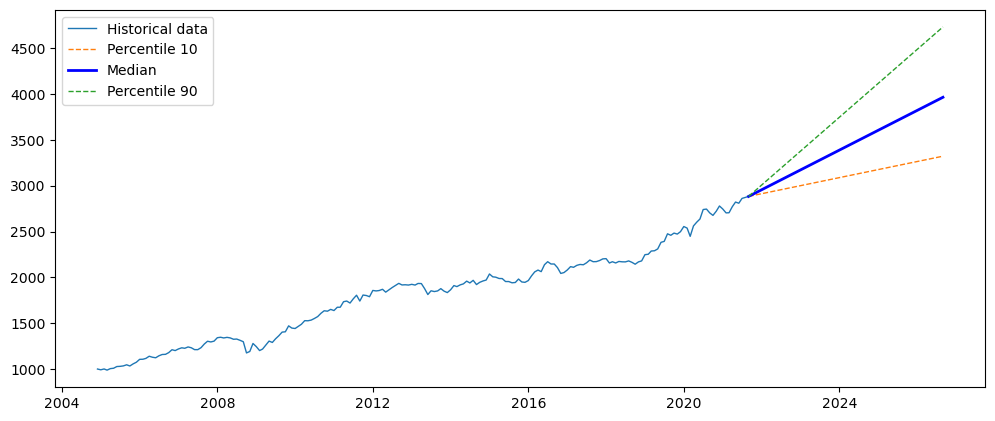

In [10]:
pf.plot_forecast(distr="norm", years=5, figsize=(12, 5));

Another way to visualize the normally distributed random forecasted data is with Monte Carlo simulation ...

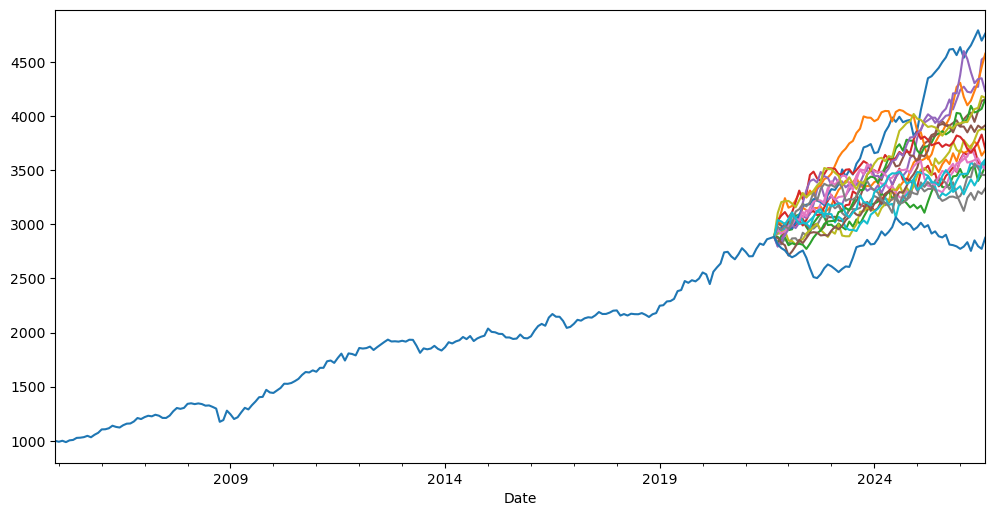

In [11]:
pf.plot_forecast_monte_carlo(
    distr="norm", years=5, n=20
)  # Generates 20 forecasted wealth indexes (for random normally distributed returns time series)

We can get numeric CAGR percentiles for each period with **percentile_distribution_cagr** method. To get credible forecast results high n values should be used.

In [12]:
pf.percentile_distribution_cagr(
    distr="norm", years=5, percentiles=[1, 20, 50, 80, 99], n=10000
)

{1: -0.0018682471918438797,
 20: 0.040275925212559606,
 50: 0.06517463802602774,
 80: 0.090346057857251,
 99: 0.13620997462262863}

The same could be used to get VAR (Value at Risk):

In [13]:
pf.percentile_distribution_cagr(
    distr="norm", years=1, percentiles=[1], n=10000
)  # 1% perecentile corresponds to 99% confidence level

{1: -0.08022557681197745}

One-year VAR (99% confidence level) is equal to 8%. It's a fair value for conservative portfolio.  
The probability of getting negative result in forecasted period is the percentile rank for zero CAGR value (score=0).

In [14]:
pf.percentile_inverse_cagr(distr="norm", years=1, score=0, n=10000)  # one year period

15.24

### Lognormal distribution

Some financial assets returns have returns distribution close to lognormal.  
The same calculations could be repeated for lognormal distribution by setting dist='lognorm'.

In [15]:
ln = ok.Portfolio(["EDV.US"], inflation=False)
ln

symbol                 portfolio_6530.PF
assets                          [EDV.US]
weights                            [1.0]
rebalancing_period                 month
currency                             USD
inflation                           None
first_date                       2008-01
last_date                        2021-09
period_length         13 years, 9 months
dtype: object

In [16]:
ln.names

{'EDV.US': 'Vanguard Extended Duration Treasury Index Fund ETF Shares'}

We can visualize the distribution and compare it with the lognormal PDF (Probability Distribution Function).

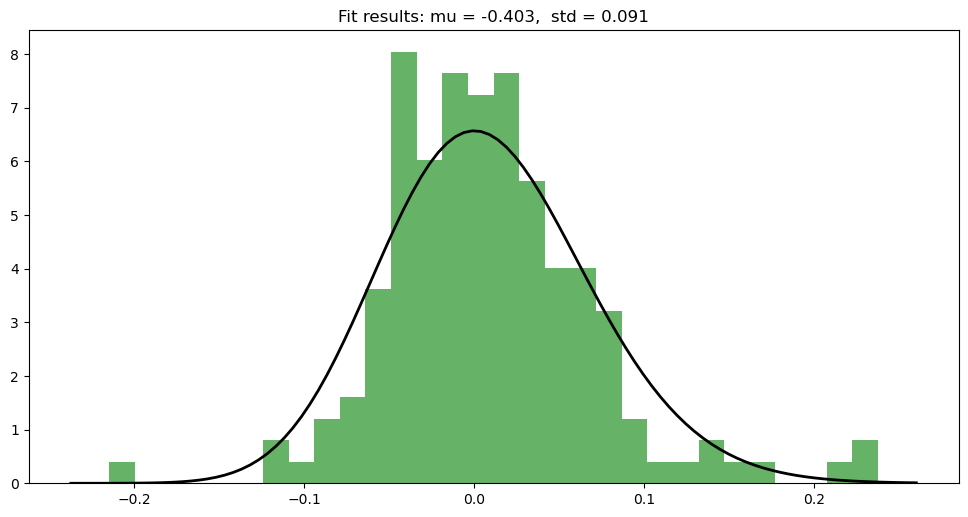

In [17]:
ln.plot_hist_fit(distr="lognorm", bins=30)

In [18]:
ln.kstest(distr="norm")  # Kolmogorov-Smirnov test for normal distribution

{'statistic': 0.07202758342073678, 'p-value': 0.34245477784344835}

In [19]:
ln.kstest(distr="lognorm")  # Kolmogorov-Smirnov test for lognormal distribution

{'statistic': 0.06328132355478305, 'p-value': 0.5032757153492596}

What is more important Kolmogorov-Smirnov test shows that historical distribution is slightly closer to lognormal.  
Therefore, we can use lognormal distribution to forecast.

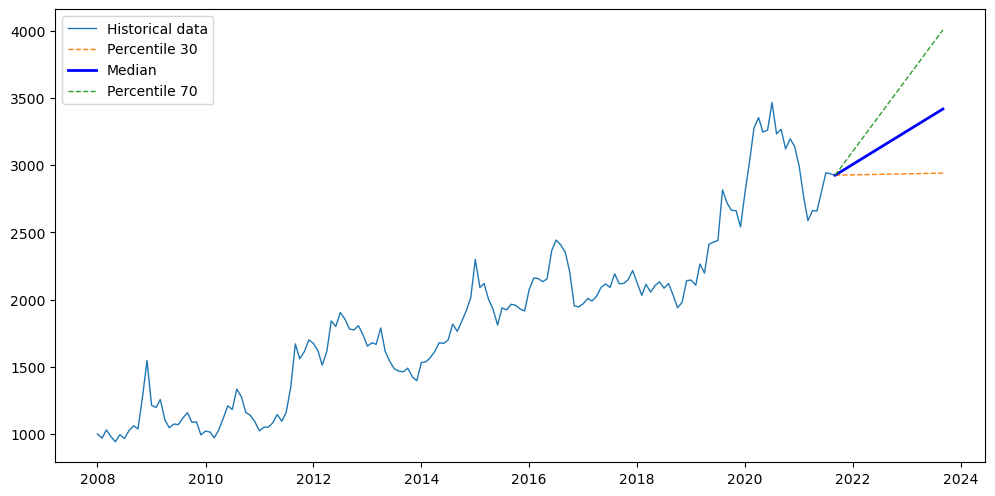

In [20]:
ln.plot_forecast(distr="lognorm", percentiles=[30, 50, 70], years=2, n=10000);

In [21]:
pf.percentile_distribution_cagr(
    distr="lognorm", years=1, percentiles=[1, 20, 50, 80, 99], n=10000
)

{1: -0.08539671840457173,
 20: 0.006845057458079897,
 50: 0.06326889111186484,
 80: 0.12623182931148105,
 99: 0.24979010711073493}

### Forecasting using historical data

If it's not possible to fit the data to normal or lognormal distributions, percentiles from the historical data could be used.

In [22]:
ht = ok.Portfolio(["SPY.US"])
ht

symbol                 portfolio_6507.PF
assets                          [SPY.US]
weights                            [1.0]
rebalancing_period                 month
currency                             USD
inflation                       USD.INFL
first_date                       1993-02
last_date                        2021-07
period_length         28 years, 6 months
dtype: object

In [23]:
ht.kstest("norm")

{'statistic': 0.07633731946092431, 'p-value': 0.03521318518992533}

In [24]:
ht.kstest("lognorm")

{'statistic': 0.07611767014644649, 'p-value': 0.03603593547607453}

Kolmogorov-Smirnov test is not passing 5% threshold...

Big deviation in the tails could be seen in Quantile-Quantile Plot.

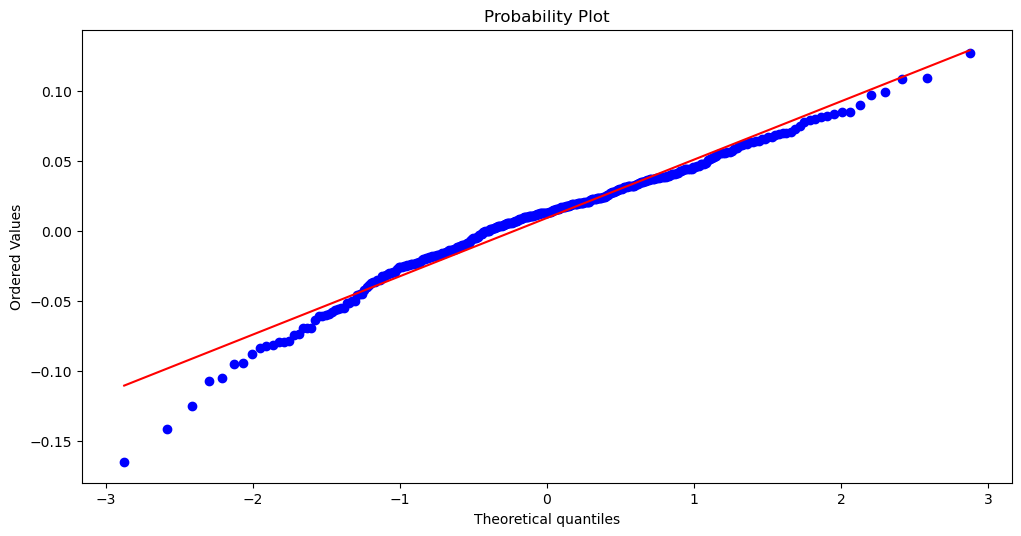

In [25]:
ht.plot_percentiles_fit("norm")

Then we can use percentiles from the historical data to forecast.

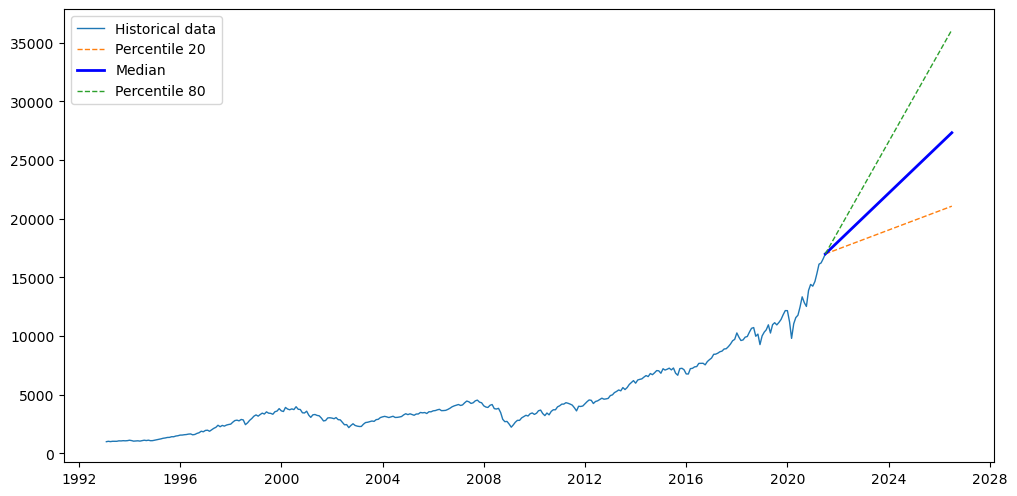

In [26]:
ht.plot_forecast(years=5, percentiles=[20, 50, 80]);

In [27]:
ht.percentile_wealth(distr="hist", years=5)

{10: 15799.730976641864, 50: 27983.6820933283, 90: 44898.06995326274}

Quantitative CAGR percentiles could be obtained from **percentile_history_cagr** method:

In [28]:
ht.percentile_history_cagr(years=5)

,10,50,90
years,,,
1,-0.127016,0.136080,0.300920
2,-0.098663,0.119072,0.258642
3,-0.069459,0.118627,0.244682
4,-0.042279,0.121011,0.228285
5,-0.014570,0.104783,0.214343


We can visualize the same to see how CAGR ranges were narrowing with investment horizon.

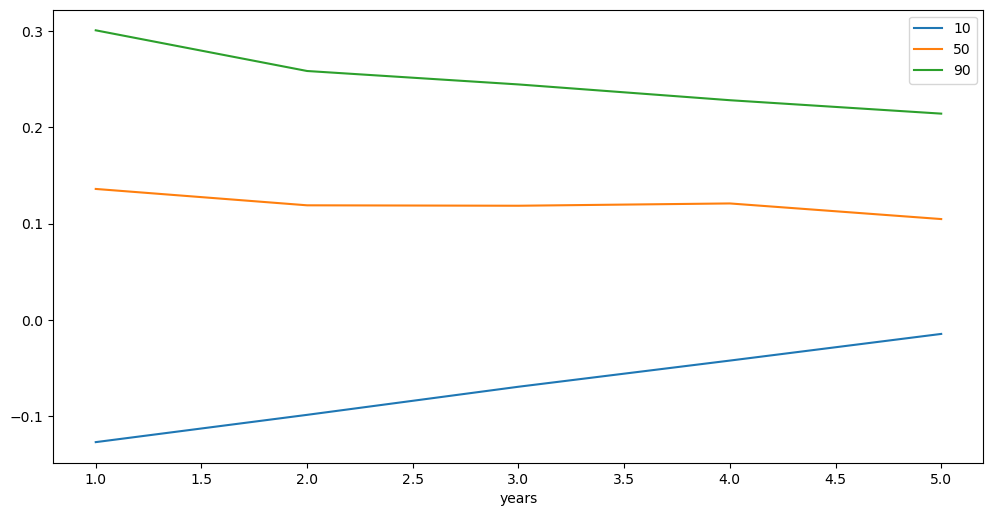

In [29]:
ht.percentile_history_cagr(years=5).plot();